# Comp Screening - cell painting compressed (OG316) analysis
## FOR COMPLTETE (datalock) cell painting dataset
#### _BEM 10-19-2021_

### What this does:
looks @ the compressed screen data - tries out enrichment decon

In [1]:
import os
import sys
import warnings
import random
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import multiprocess as mp
from itertools import repeat
from scipy.stats import mode
from sklearn.metrics import silhouette_score
from sklearn.covariance import EmpiricalCovariance
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests

pd.set_option('mode.chained_assignment', None)
data_path = '../1_Data/'

## Define Functions

#### Hide annoying prints

In [3]:
class HiddenPrints:
    """
    Class to hide unnecessary prints
    """
    
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

#### Mahalanobis calcs

In [4]:
def mahala_dist_CS(adata, use_rep='X', std_cutoff=3, n_sample=10000, assume_centered=False, num_pcs=None):
    """
    Calculates the mahalanobis disance of the pert. avg and provides a standard deviation cutoff based on DMSO null dist
    in adata using MCD robust estimator trained on DMSO + avg Pert., stores values as metadata
    """
    
    # weight PCs by variance explained
    adata.obsm['X_pca_weighted'] = np.multiply(adata.obsm['X_pca'],adata.uns['pca']['variance_ratio'])
    adata.obsm['X_pca_harmony_weighted'] = np.multiply(adata.obsm['X_pca_harmony'],adata.uns['pca']['variance_ratio'])
    
    # select data
    adata_DMSO = adata[adata.obs.Metadata_perturbation=='DMSO',:]
    adata_pert = adata[~(adata.obs.Metadata_perturbation=='DMSO'),:]
    
    if use_rep == 'X':
        X_DMSO = adata_DMSO.X
        X_pert = pd.DataFrame()

        for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
            pert = pd.DataFrame(np.multiply(adata_pert.X, adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
            pert = pert.loc[~(pert==0).all(axis=1)]
            pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
            pert = pert.set_index('Metadata_perturbation')
            X_pert = pd.concat([X_pert, pert])

    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame()

            for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
                pert = pd.DataFrame(np.multiply(adata_pert.obsm['X_pca_weighted'][:,0:num_pcs], 
                                                adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
                pert = pert.loc[~(pert==0).all(axis=1)]
                pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
                pert = pert.set_index('Metadata_perturbation')
                X_pert = pd.concat([X_pert, pert])
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_harmony_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame()

            for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
                pert = pd.DataFrame(np.multiply(adata_pert.obsm['X_pca_harmony_weighted'][:,0:num_pcs], 
                                                adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
                pert = pert.loc[~(pert==0).all(axis=1)]
                pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
                pert = pert.set_index('Metadata_perturbation')
                X_pert = pd.concat([X_pert, pert])
    
    else:
        print('use_rep is not valid option')
        return
    
    # average by perturbation
    X_avg_pert = X_pert.groupby('Metadata_perturbation').mean()

    # fit covariance estimator to control + avg. pert. sample
    cov = EmpiricalCovariance(assume_centered=assume_centered).fit(X_DMSO)

    # calclute perturbation mahalanois distances
    if assume_centered:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert))
    else:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert-cov.location_))
    
    # sample DMSO null distribution
    n_rep = mode(X_pert.iloc[:,0].groupby('Metadata_perturbation').count()).mode[0]
    n_DMSO = len(X_DMSO)
    DMSO_null = np.mean(X_DMSO[np.random.randint(0,n_DMSO,size=(n_sample,n_rep))], axis=1)
    
    #calc DMSO null mahalanobis
    if assume_centered:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null))
    else:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null-cov.location_))
    
    # empirical stdev cutoff for pert vs. null DMSO
    pass_value = (np.std(DMSO_mahal)*std_cutoff)+np.mean(DMSO_mahal)
    
    # build pert table
    mahala_table = pd.DataFrame(pert_mahal, 
                                index=X_avg_pert.index,
                                columns=['mahalanobis'])
    mahala_table['signif_mahala'] = (pert_mahal > pass_value)
    mahala_table.reset_index(inplace=True)
    
    # make mahala table for plotting    
    dmso_table = pd.DataFrame(np.random.choice(DMSO_mahal, size=n_DMSO*5, replace=False),
                              columns=['mahalanobis'])
    dmso_table['Metadata_perturbation'] = 'DMSO'
    dmso_table['signif_mahala'] = 'DMSO'
    
    mahala_table = pd.concat([mahala_table, dmso_table])
    
    return mahala_table    

#### Fingerprint enrichments

In [5]:
def pull_Cluster_adata(adata):
    """
    pulls out perturbation clustering from adata FOR COMPRESSED SCREEN
    """
    adata.obs['leiden'] = adata.obs.leiden.astype(str)
    adata.obs.loc[adata.obs.leiden=='DMSO','leiden'] = '1234'
    
    adata_DMSO = adata[adata.obs.Metadata_perturbation=='DMSO',:]
    adata_pert = adata[~(adata.obs.Metadata_perturbation=='DMSO'),:]
    
    cluster_table = pd.DataFrame()

    for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
        pert = pd.DataFrame(np.multiply(adata_pert.obs.leiden.astype(int).values, 
                                        adata_pert.obsm['design_matrix'][:,i].astype(int)))
        pert = pert.loc[~(pert==0).all(axis=1)]
        pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
        pert = pert.set_index('Metadata_perturbation')
        cluster_table = pd.concat([cluster_table, pert])
        
    DMSO_table = adata_DMSO.obs.loc[:,adata_DMSO.obs.columns.isin(['Metadata_perturbation',
                                                                   'leiden'])].set_index('Metadata_perturbation')
    
    DMSO_table.leiden = DMSO_table.leiden.astype(int)
    
    cluster_table.columns = ['leiden']
    cluster_table = pd.concat([cluster_table, DMSO_table])
    cluster_table = cluster_table.reset_index()
    cluster_table.loc[cluster_table.leiden==1234,'leiden'] = 'DMSO'
    cluster_table.leiden = cluster_table.leiden.astype(str)
    
    return cluster_table

def Cluster_ZS_enrich(table, table_type='adata'):
    """
    input: andata with metadata or cluster table with columns 
           'Metadata_perturbation' and 'leiden' (clustering) 

    method: calc sample-wise abundance, z-score transform over all samples per cluster
    
    output: new andata with .X slot as enrchment table (pertrub x leiden cluster), 
            metadata for perturbation
    """    
    
    # Build cluster table
    if table_type == 'adata':
        cluster_table = pull_Cluster_adata(table)
        
    elif table_type == 'cluster_table':
        cluster_table = table
        
    else:
        print('table_type is not valid option')
        return
    
    # Build perturb count table
    perturb_count_table = pd.DataFrame({'Metadata_perturbation':list(set(cluster_table.Metadata_perturbation.values))})
    grouped = cluster_table.groupby('leiden')

    for name, group in grouped:
        name_table = group.groupby('Metadata_perturbation').count().rename(columns={'leiden':name}).reset_index()
        perturb_count_table = perturb_count_table.merge(name_table, on='Metadata_perturbation',how='left')

    perturb_count_table = perturb_count_table.fillna(0)
    perturb_count_table.set_index('Metadata_perturbation', inplace=True)
    count_table = np.array(perturb_count_table)
    
    # Convert perturbation table to abundances or Z-scores
    # counts to sample-wise abundance
    perturb_count_table = perturb_count_table.div(perturb_count_table.sum(axis=1), axis=0)
    
    # Z-score tranform abundance within each cluster
    col_mean = perturb_count_table.mean(axis=0)
    col_std = perturb_count_table.std(axis=0)
    perturb_count_table = perturb_count_table.sub(col_mean, axis=1).div(col_std, axis=1)
    
    edata = anndata.AnnData(X = perturb_count_table.reset_index(drop=True))
    edata.obs['Metadata_perturbation'] = perturb_count_table.index.values
    edata.obsm['count_table'] = count_table
    
    return edata

In [6]:
#### Function to calculate pertubation / pg cluster p-value

def shuffle_count(run, cluster_table, enrich_array):
    """
    shuffles cluster table and returns array where shuffle enrich > non-shuffle
    """
    
    # shuffle cluster_table
    shuff_cluster_table = cluster_table.set_index('Metadata_perturbation')
    index = shuff_cluster_table.index.values
    shuff_cluster_table = shuff_cluster_table.sample(frac=1).reset_index(drop=True)
    shuff_cluster_table['Metadata_perturbation'] = index

    # run cluster enrichment on shuffled table
    shuff_edata = Cluster_ZS_enrich(shuff_cluster_table, table_type='cluster_table')
    
    return (shuff_edata.X > enrich_array).astype(int)
        
def CZSe_shuffle_test(adata, num_shuffle=10000):
        
    # run cluster zs enrichment on non-shuffled data
    cluster_table = pull_Cluster_adata(adata)
    edata = Cluster_ZS_enrich(cluster_table, table_type='cluster_table')
    
    # shuffle cluster assignments to compute p-val
    if num_shuffle > (mp.cpu_count()-1):
        p_size = (mp.cpu_count()-1)
    else:
        p_size = len(num_shuffle)
    
    runs = list(range(num_shuffle))
    pool = mp.Pool(p_size)
    pval = sum(pool.starmap(shuffle_count, zip(runs,repeat(cluster_table),repeat(edata.X))))
    pool.close()
    pool.join()
    
    edata.obsm['pval'] = pval/num_shuffle
    
    return edata

#### Resolution scanning

In [7]:
def res_scan(adata, use_rep='X', res_min=0.1, res_max=3.0, res_num=30, num_shuffle=10000, num_pcs=None):
    """
    Finds the optimal resolution for a feature set by identifying the resolution at which the metrics
    are the highest via scanpy leiden clustering
    """

    # select data
    if use_rep == 'X':
        features = adata.X
        
    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            features = adata.obsm['X_pca'][:,0:num_pcs]
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            features = adata.obsm['X_pca_harmony'][:,0:num_pcs]  
    
    else:
        print('use_rep is not valid option')
        return
    
    warnings.filterwarnings("ignore") # don't print a bunch of annoying pandas crap
    
    # resolutions to test: defaults to 0.1 to 3.0, by steps of 0.1
    res_scan  = np.linspace(res_min,res_max,num=res_num)

    # Loop through the resolutions and calculate the cluster membership
    silhouette = []
    num_clust = []
    dmso_clust = []
    ns_clust = []
    dmso_frac = []
    single_sig_frac = []
    multi_sig_frac = []

    for i in range(res_num):

        res = res_scan[i]

        # Run clustering
        with HiddenPrints():
            sc.tl.leiden(adata, resolution = res)
            adata.obs.leiden = adata.obs.leiden.astype(int) + 1 
            adata.obs.leiden = adata.obs.leiden.astype('category')
        
        # Calc metrics
        silhouette.append(silhouette_score(features, adata.obs.leiden.values))
        num_clust.append(len(set(adata.obs.leiden.values)))
        
        edata = CZSe_shuffle_test(adata, num_shuffle=num_shuffle)
        dmso_sig = (edata.obsm['pval'][edata.obs.Metadata_perturbation == 'DMSO'] < 0.05)
        dmso_count = edata.obsm['count_table'][edata.obs.Metadata_perturbation == 'DMSO']
        pert_sig = (edata.obsm['pval'][edata.obs.Metadata_perturbation != 'DMSO'] < 0.05)
        
        dmso_clust.append(np.sum(dmso_sig))
        ns_clust.append(np.sum(~np.delete(np.sum(~dmso_sig*pert_sig, axis=0)>0, np.where(dmso_sig))))
        
        dmso_frac.append(np.sum(dmso_sig*dmso_count/np.sum(dmso_count)))
        single_sig_frac.append(np.sum(np.sum(~dmso_sig*pert_sig, axis=1)==1)/np.shape(pert_sig)[0])
        multi_sig_frac.append(np.sum(np.sum(~dmso_sig*pert_sig, axis=1)>1)/np.shape(pert_sig)[0])

    res_table = pd.DataFrame({"resolution":res_scan,
                              "num_clusters":num_clust,
                              "num_DMSO_clusters":dmso_clust,
                              "num_ns_clusters":ns_clust,
                              "mean_silhouette":silhouette,
                              "frac_single_pert_sig":single_sig_frac,
                              "frac_multi_pert_sig":multi_sig_frac,
                              "frac_DMSO_in_DMSO_clust":dmso_frac})
    
    return res_table

#### Feature enrichment plotting

In [8]:
def Feat_enrich_plot(adata, file_name, ref='rest', n_top_feats=50):
    """
    for adata run 'rank_genes_groups' retain the n_top_feats plot how each cluster is enriched 
    for that feature set's compartment and channel
    """
    
    # figure out what makes the other clusters unique / enriched features
    sc.tl.rank_genes_groups(adata, 'leiden', reference=ref, method='wilcoxon', n_genes=n_top_feats)
    
    if ref == 'DMSO':
        clusters = list(set(adata.obs.leiden.values)-{'DMSO'})
    else:
        clusters = list(set(adata.obs.leiden.values))

    full_table = pd.DataFrame()

    for c in clusters:

        enriched_feats = list(adata.uns['rank_genes_groups']['names'][c])

        enriched_table = adata.var.loc[adata.var.index.isin(enriched_feats)].reset_index().astype(str)
        enriched_table = enriched_table.drop(['measure'], axis=1).groupby(['compartment','channel']).count()
        enriched_table.columns = [c]

        if c == clusters[0]:
            full_table = enriched_table
        else:
            full_table = enriched_table.merge(full_table, how='outer', right_index=True, left_index=True)

    full_table = full_table.fillna(0)
    full_table = pd.DataFrame(full_table.stack())
    full_table.index = full_table.index.rename(['compartment','channel','leiden'])
    full_table.columns = ['num_feat']
    
    # make plots
    channel_order = ['DNA', 'Nucleoli', 'ER', 'Golgi', 'Mito', 'AreaShape', 'Neighbors']
    colors = ['#8da0cb', '#a6d854', '#ffd92f', '#e78ac3', '#fc8d62', '#e5c494', '#b3b3b3']
    
    ax = sns.displot(full_table, x='compartment', hue='channel', col='leiden', hue_order = channel_order, weights='num_feat',
                 multiple='stack', palette=colors, shrink=0.8, height=2, aspect=0.75, legend=True)
    ax.set(ylabel = 'top features');

    ax.savefig("figures/"+file_name+"_"+ref+"_"+"top_"+str(n_top_feats)+"_feat_enrich_plot.pdf");

    return

## Analysis

### Load in anndata

In [2]:
# PCA harmony data
OG316 = anndata.read_h5ad(data_path+'09272021_PCH_rd_OG316_table.h5ad')

# add metadata for landmarks
LM_list = ['DMSO','Doxorubicin','Daunorubicin','Fluvastatin','Ticlopidine',
           'Tropicamide','Mycophenolic Acid','Vinblastine Sulfate','Riluzole']

LM_df = pd.DataFrame(columns = LM_list)

for LM in LM_list:
    LM_df[LM] = (OG316.obs.Metadata_perturbation == LM)
    LM_df[LM] = OG316.obs.Metadata_perturbation[(OG316.obs.Metadata_perturbation == LM)]

    OG316.obs[LM] = LM_df[LM]

OG316.obs['landmarks'] = LM_df.astype(str).replace('nan', '').sum(axis=1)
OG316.obs.loc[OG316.obs.landmarks == '', 'landmarks'] = np.nan

# Add feature descriptors
feature_desc = pd.DataFrame(list(OG316.var_names))[0].str.split('_', n=2, expand=True)
feature_desc.columns = ['compartment','measure','channel']
feature_desc['channel'] = feature_desc.channel.str.split('_', expand=False).str.get(1)

OG316.var['compartment'] = feature_desc.compartment.values
OG316.var['measure'] = feature_desc.measure.values
OG316.var['channel'] = feature_desc.channel.values
OG316.var.loc[OG316.var.channel.isna(), 'channel'] = OG316.var.loc[OG316.var.channel.isna(), 'measure']
digits = ['0','1','2','3','4', '5', '6', '7', '8', '9']
OG316.var.loc[OG316.var.channel.isin(digits), 'channel'] = OG316.var.loc[OG316.var.channel.isin(digits), 'measure']
OG316.var.loc[OG316.var.channel == 'Adjacent', 'channel'] = OG316.var.loc[OG316.var.channel == 'Adjacent', 'measure']

# filter to only compressed data
C316 = OG316[~OG316.obs.Metadata_run.isin(['GT_run2', 'GT_run1_batch1']),:]


In [3]:
# filter to single run & add design matrix

r1_4x5r = C316[(C316.obs.Metadata_run=='CS_run1')&\
               (C316.obs.Metadata_perturbation.isin(['random', 'DMSO']))&\
               (C316.obs.Metadata_compression==4)&\
               (C316.obs.Metadata_replicates==5),:]

r1_4x5r.obs['design_index']=r1_4x5r.obs.Metadata_Plate.astype(str)+'_'+r1_4x5r.obs.Metadata_Well.astype(str)

# load in design matricies
run1_design = pd.read_csv(data_path+'CS_run1_PCH_rd_OG316_design_matrix.csv',index_col=0).reset_index().rename(columns={'index':'design_index'})

# add design matrix
design_mat = pd.DataFrame(r1_4x5r.obs['design_index']).\
             merge(run1_design,how='left',on='design_index').\
             drop(['design_index'],axis=1)

r1_4x5r.obsm['design_matrix']=np.array(design_mat)
r1_4x5r.uns['design_matrix_perturbations'] = design_mat.columns.values.tolist()

# filter to reps
plate = list(set(r1_4x5r.obs.loc[r1_4x5r.obs.Metadata_perturbation=='random','Metadata_Plate'].values))

r1_4x5r1 = r1_4x5r[(r1_4x5r.obs.Metadata_Plate==plate[0]),:]

Trying to set attribute `.obs` of view, copying.


### Determine num_PCs, neighbors, UMAP

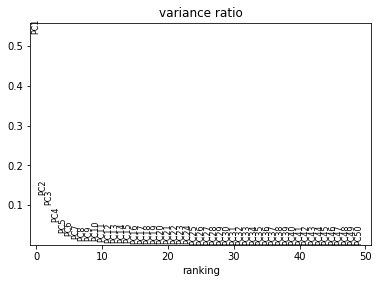

90% of variance explained by 9 PCs


In [4]:
# recalc PC's for dataset
sc.pp.pca(r1_4x5r1)

# single plate (no need to batch correct)

# get num of PCs to use (up to 90% var explained)
sc.pl.pca_variance_ratio(r1_4x5r1, n_pcs = 50, log=False)
num_pcs = sum(np.cumsum(r1_4x5r1.uns['pca']['variance_ratio']) < 0.9)+1

print('90% of variance explained by '+str(num_pcs)+' PCs')

### Determine Signif Pertrubs by Mahalnobis Dist

In [18]:
mahala_table = mahala_dist_CS(r1_4x5r1, std_cutoff=8, use_rep='X_pca', num_pcs=num_pcs)

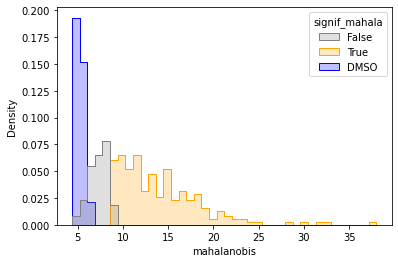

In [19]:
g = sns.histplot(mahala_table, x='mahalanobis', 
                 element="step", multiple='layer', stat='density', bins = 40,
                 hue="signif_mahala", palette=['grey','orange', 'blue'])

g.figure.savefig("figures/CS316_r1_4x5r_mahala_sig_plot.pdf");

In [20]:
sig_drugs = set(mahala_table.loc[mahala_table.signif_mahala==True,'Metadata_perturbation'].values)

print(str(len(sig_drugs))+' significant drugs')

pd.DataFrame({'mahala_sig_compounds':list(sig_drugs)}).to_csv('CS316_mahala_sig.csv', index=False)
mahala_table.to_csv('CS316_mahala.csv', index=False)


221 significant drugs


### Resolution scanning

In [61]:
sc.pp.neighbors(r1_4x5r1, n_neighbors=int(np.round(0.5*np.sqrt(np.shape(r1_4x5r1.X)[0]))), 
                n_pcs=num_pcs, use_rep = 'X_pca')
sc.tl.umap(r1_4x5r1)

In [15]:
ms_res_table = res_scan(r1_4x5r1, use_rep='X_pca', res_num=60, num_shuffle=5000, num_pcs=num_pcs)
ms_res_table.to_csv('10212021_CS316_r1_4x5r_mahal_sig_res_scan.csv')

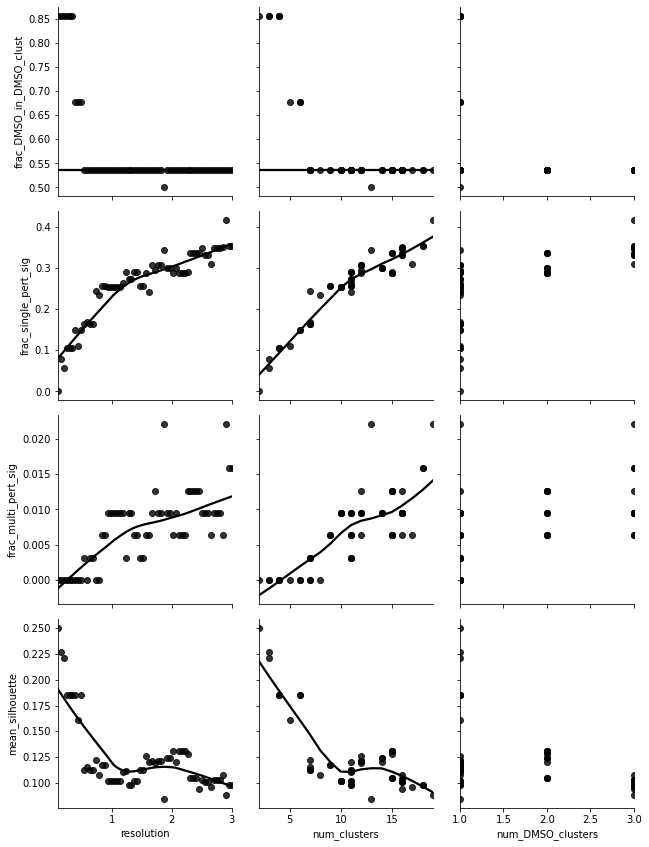

In [16]:
ms_res_table = pd.read_csv('10212021_CS316_r1_4x5r_mahal_sig_res_scan.csv')

g = sns.PairGrid(ms_res_table, y_vars=["frac_DMSO_in_DMSO_clust",'frac_single_pert_sig','frac_multi_pert_sig','mean_silhouette'], 
                 x_vars=["resolution", 'num_clusters', 'num_DMSO_clusters'], height=3)
g.map(sns.regplot, lowess=True, color = 'black')

g.savefig("figures/CS316_r1_4x5r_res_scan_plot.pdf");

### Plotting @ chosen Resolution

In [94]:
sc.tl.leiden(r1_4x5r1, resolution = 2)
r1_4x5r1.obs.leiden = r1_4x5r1.obs.leiden.astype(int) + 1 
r1_4x5r1.obs.leiden = r1_4x5r1.obs.leiden.astype('category')

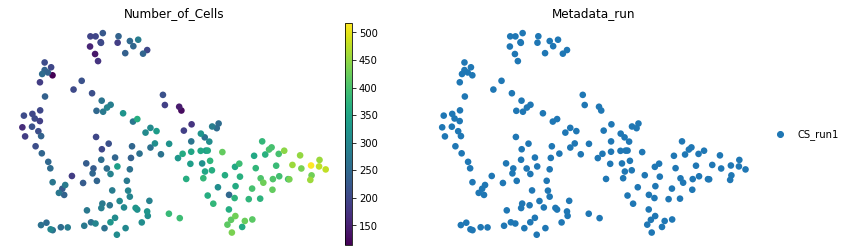

In [95]:
sc.pl.umap(r1_4x5r1, color=['Number_of_Cells','Metadata_run'], ncols = 2, frameon=False, size=175, 
           save = 'CS_r1_4x5r_UMAP_cell_batch.pdf')

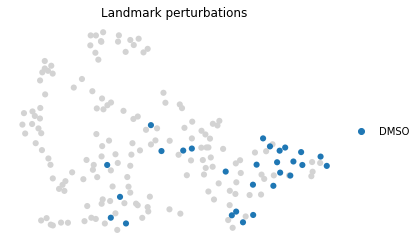

In [96]:
sc.pl.umap(r1_4x5r1, color='landmarks',
           legend_fontsize=10,frameon=False, na_in_legend=False, size=150,
           title='Landmark perturbations', palette='tab20', save = 'CS_r1_4x5r_UMAP_landmarks.pdf')

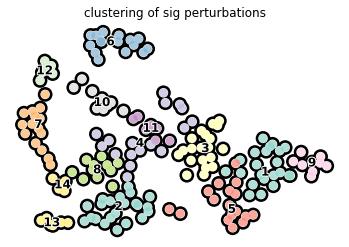

In [97]:
sc.pl.umap(r1_4x5r1, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, size=300,
           title='clustering of sig perturbations', palette='Set3', save = 'CS_r1_4x5r_UMAP_leiden_160.pdf')

### Cluster Enrichment Analysis

In [59]:
# generate enrichment table
r1_4x5r1_enrich = CZSe_shuffle_test(r1_4x5r1, num_shuffle=10000)

In [60]:
# list dmso-enriched clusters
dmso_sig = (r1_4x5r1_enrich.obsm['pval'][r1_4x5r1_enrich.obs.Metadata_perturbation == 'DMSO'] < 0.05)
dmso_clusters = [i for i in (dmso_sig*r1_4x5r1_enrich.var_names.astype(str).values)[0].tolist() if i]

In [61]:
# re-name dmso clusters
r1_4x5r1.obs.leiden = r1_4x5r1.obs.leiden.astype(str).values

for i,x in enumerate(r1_4x5r1.obs.leiden):
    if x in dmso_clusters:
        r1_4x5r1.obs.leiden[i] = 'DMSO'
        

... storing 'leiden' as categorical


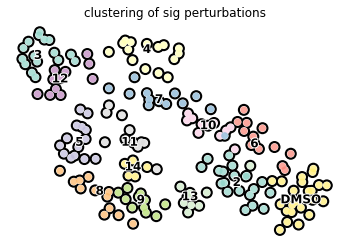

In [62]:
sc.pl.umap(r1_4x5r1, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, size=200,
           title='clustering of sig perturbations', palette='Set3', save = 'CS_r1_4x5r_UMAP_rename.pdf')

In [63]:
# save metadata file with clusters for image pull
cols = ['Metadata_Plate', 'Metadata_Well', 'leiden']
metadata = SGT316.obs.loc[:,SGT316.obs.columns.isin(cols)]
metadata.to_csv('SGT316_metadata_image_pull.csv')

NameError: name 'SGT316' is not defined

/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


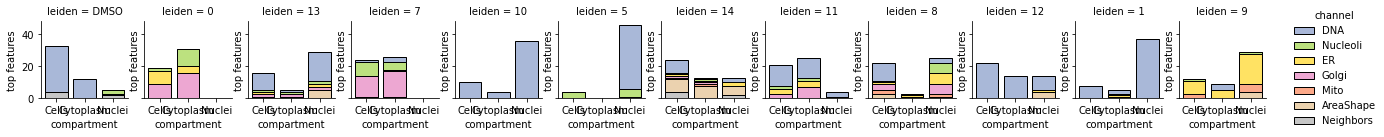

In [119]:
# figure out what makes the other clusters unique / enriched features
Feat_enrich_plot(SGT316, 'SGT316', n_top_feats=50)

#### Group significant perturbations

In [64]:
# generate DMSO enrichment table
r1_4x5r_enrich2 = CZSe_shuffle_test(r1_4x5r1, num_shuffle=10000)

In [65]:
dmso_sig = (r1_4x5r_enrich2.obsm['pval'][r1_4x5r_enrich2.obs.Metadata_perturbation == 'DMSO'] < 0.05)
pert_sig = (r1_4x5r_enrich2.obsm['pval'][r1_4x5r_enrich2.obs.Metadata_perturbation != 'DMSO'] < 0.05)

In [66]:
sig_table = pd.DataFrame((r1_4x5r_enrich2.obsm['pval'] < 0.01),
                         index=r1_4x5r_enrich2.obs.Metadata_perturbation.values,
                         columns=r1_4x5r_enrich2.var_names.values)

clust_col = set(sig_table.columns.values)-{'DMSO'}
sig_table['sig_comp'] = sig_table[clust_col].sum(axis=1).values
sig_compounds = list(sig_table.loc[(sig_table.sig_comp>0)&~(sig_table.DMSO), :].index.values.astype(str))

In [67]:
sig_compounds

['Ergotamine Tartrate',
 'Vinblastine Sulfate',
 'Zafirlukast',
 'Quetiapine Fumarate',
 'Mitoxantrone',
 'Albendazole',
 'Terbinafine',
 'Lamotrigine',
 'Diphenhydramine',
 'Haloperidol ',
 'Gemcitabine',
 'Promethazine',
 'Aspirin (Acetylsalicylic Acid)',
 'Goserelin Acetate',
 'Doxorubicin',
 'Mitomycin C',
 'Caffeine ',
 'Aztreonam',
 'Betaxolol',
 'Ethacrynic Acid',
 'Mesalamine (5-Aminosalicylic Acid)',
 'Daunorubicin',
 'Celecoxib',
 'Lapatinib Ditosylate',
 'Phentolamine',
 'Disulfiram',
 'Tropicamide',
 'Naphazoline',
 'Cefotaxime Acid',
 'Zolmitriptan',
 'Adapalene',
 'Oxacillin sodium salt monohydrate',
 'Metronidazole',
 'Nimodipine',
 'Levonorgestrel',
 'Melphalan',
 'Olanzapine',
 'Idarubicin',
 'Clarithromycin',
 'Fluvastatin',
 'Etoposide',
 'Metformin',
 'Sirolimus (Rapamycin)',
 'Mycophenolic Acid']

In [68]:
r1_4x5r_enrich2.obs['sig_compound'] = False

for c in sig_compounds+['DMSO']:
    r1_4x5r_enrich2.obs.loc[r1_4x5r_enrich2.obs.Metadata_perturbation==c,'sig_compound'] = True
    
r1_4x5r_enrich2 = r1_4x5r_enrich2[r1_4x5r_enrich2.obs.sig_compound,:]

In [87]:
sc.pp.neighbors(r1_4x5r_enrich2, n_neighbors=int(np.round(0.5*np.sqrt(np.shape(r1_4x5r_enrich2.X)[0]))),
                use_rep ='X')
sc.tl.umap(r1_4x5r_enrich2)

In [88]:
r1_4x5r_enrich2.obs.Metadata_perturbation = r1_4x5r_enrich2.obs.Metadata_perturbation.astype('category')

In [89]:
sc.tl.leiden(r1_4x5r_enrich2, resolution = 0.7)

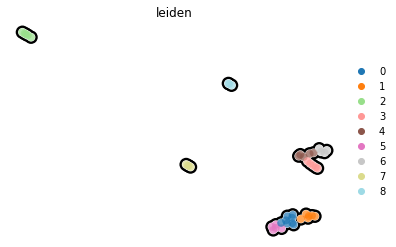

In [90]:
sc.pl.umap(r1_4x5r_enrich2, color='leiden', add_outline=True,frameon=False, size=250,
           palette='tab20', save = 'r1_4x5r_enrich_UMAP_perturbs.pdf')

In [91]:
r1_4x5r_enrich2.obs.to_csv('r1_4x5r_clusterenrich_clusters.csv', index=False)